This notebook is based on: [DoWhy-The Causal Story Behind Hotel Booking Cancellations](https://www.pywhy.org/dowhy/v0.8/example_notebooks/DoWhy-The%20Causal%20Story%20Behind%20Hotel%20Booking%20Cancellations.html)

In [ ]:
!pip install pandas numpy matplotlib networkx dowhy

In [2]:
# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'INFO',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

#!pip install dowhy
import dowhy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

c:\Users\Bertram Taetz\gitRepos\DLMAIIAC\Sprint_November_2024\Session_6\venv_apps\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = pd.read_csv('https://raw.githubusercontent.com/Sid-darthvader/DoWhy-The-Causal-Story-Behind-Hotel-Booking-Cancellations/master/hotel_bookings.csv')
dataset.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
dataset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

# Feature Engineering
Lets create some new and meaningful features so as to reduce the dimensionality of the dataset. - Total Stay = stays_in_weekend_nights + stays_in_week_nights - Guests = adults + children + babies - Different_room_assigned = 1 if reserved_room_type & assigned_room_type are different, 0 otherwise.

In [4]:
# Total stay in nights
dataset['total_stay'] = dataset['stays_in_week_nights']+dataset['stays_in_weekend_nights']
# Total number of guests
dataset['guests'] = dataset['adults']+dataset['children'] +dataset['babies']
# Creating the different_room_assigned feature
dataset['different_room_assigned']=0
slice_indices =dataset['reserved_room_type']!=dataset['assigned_room_type']
dataset.loc[slice_indices,'different_room_assigned']=1
# Deleting older features
dataset = dataset.drop(['stays_in_week_nights','stays_in_weekend_nights','adults','children','babies'
                        ,'reserved_room_type','assigned_room_type'],axis=1)

dataset.isnull().sum() # Country,Agent,Company contain 488,16340,112593 missing entries
dataset = dataset.drop(['agent','company'],axis=1)
# Replacing missing countries with most freqently occuring countries
dataset['country']= dataset['country'].fillna(dataset['country'].mode()[0])

dataset = dataset.drop(['reservation_status','reservation_status_date','arrival_date_day_of_month'],axis=1)
dataset = dataset.drop(['arrival_date_year'],axis=1)
dataset = dataset.drop(['distribution_channel'], axis=1)

# Replacing 1 by True and 0 by False for the experiment and outcome variables
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(1,True)
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(0,False)
dataset['is_canceled']= dataset['is_canceled'].replace(1,True)
dataset['is_canceled']= dataset['is_canceled'].replace(0,False)
dataset.dropna(inplace=True)
print(dataset.columns)
dataset.iloc[:, 5:20].head(100)

dataset = dataset[dataset.deposit_type=="No Deposit"]
dataset.groupby(['deposit_type','is_canceled']).count()

dataset_copy = dataset.copy(deep=True)
dataset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'arrival_date_week_number', 'meal', 'country', 'market_segment',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_stay', 'guests', 'different_room_assigned'],
      dtype='object')


C:\Users\Bertram Taetz\AppData\Local\Temp\ipykernel_5204\2865943646.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['different_room_assigned']= dataset['different_room_assigned'].replace(0,False)
C:\Users\Bertram Taetz\AppData\Local\Temp\ipykernel_5204\2865943646.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['is_canceled']= dataset['is_canceled'].replace(0,False)


Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'arrival_date_week_number', 'meal', 'country', 'market_segment',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_stay', 'guests', 'different_room_assigned'],
      dtype='object')

# Calculating Expected Counts
Since the number of cancellations and the number of times a different room was assigned is heavily imbalanced, we first choose 1000 observations at random to see that in how many cases do the variables; ‘is_cancelled’ & ‘different_room_assigned’ attain the same values. This whole process is then repeated 10000 times and the expected count turns out to be near 50% (i.e. the probability of these two variables attaining the same value at random). So statistically speaking, we have no definite conclusion at this stage. Thus assigning rooms different to what a customer had reserved during his booking earlier, may or may not lead to him/her cancelling that booking.

In [5]:
nCanceled = dataset[dataset["is_canceled"] == True].shape[0]
nNotCanceled = dataset[dataset["is_canceled"] == False].shape[0]
nDiffRooms = dataset[dataset["different_room_assigned"] == True].shape[0]
nNotDiffRooms = dataset[dataset["different_room_assigned"] == False].shape[0]
#nDiffRooms = dataset[dataset["different_room_assigned"] == dataset["is_canceled"]].shape[0]
#nDiffRooms
#nCanceled
print (f"Amount of is canceled (True / False): {nCanceled} / {nNotCanceled}, amount of different rooms assigned (True/False): {nDiffRooms} / {nNotDiffRooms}  ")

Amount of is canceled (True / False): 29690 / 74947, amount of different rooms assigned (True/False): 14793 / 89844  


In [28]:
counts_sum=0
nReps = 1000
nSamples = 1000
for i in range(1,nReps):
        counts_i = 0
        rdf = dataset.sample(nSamples)
        counts_i = rdf[rdf["is_canceled"] == rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
expectedValue = counts_sum/nReps

print(f" P(is_canceled | different_room_assigned) = {expectedValue / nSamples}")

 P(cancel | different_room_assigned) = 0.5885585


We now consider the scenario when there were no booking changes and recalculate the expected count.

In [30]:
# Expected Count when there are no booking changes
counts_sum=0
nReps = 1000
nSamples = 1000
for i in range(1,nReps):
        counts_i = 0
        rdf = dataset[dataset["booking_changes"]==0].sample(nSamples)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
expectedValue = counts_sum/nReps

print(f" P(is_canceled | different_room_assigned) = {expectedValue / nSamples}")

 P(is_canceled | different_room_assigned) = 0.5729715999999999


In the 2nd case, we take the scenario when there were booking changes(>0) and recalculate the expected count.

In [31]:
# Expected Count when there are booking changes = 66.4%
counts_sum=0
nReps = 1000
nSamples = 1000
for i in range(1,nReps):
        counts_i = 0
        rdf = dataset[dataset["booking_changes"]>0].sample(nSamples)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
expectedValue = counts_sum/nReps

print(f" P(is_canceled | different_room_assigned) = {expectedValue / nSamples}")

 P(is_canceled | different_room_assigned) = 0.6654260000000001


There is definitely some change happening when the number of booking changes are non-zero. So it gives us a hint that Booking Changes may be affecting room cancellation.

But is Booking Changes the only confounding variable? What if there were some unobserved confounders, regarding which we have no information(feature) present in our dataset. Would we still be able to make the same claims as before?

## Using DoWhy to estimate the causal effect
# Step-1. Create a Causal Graph
Represent your prior knowledge about the predictive modelling problem as a CI graph using assumptions. Don’t worry, you need not specify the full graph at this stage. Even a partial graph would be enough and the rest can be figured out by DoWhy ;-)

Here are a list of assumptions that have then been translated into a Causal Diagram:-

Market Segment has 2 levels, “TA” refers to the “Travel Agents” and “TO” means “Tour Operators” so it should affect the Lead Time (which is simply the number of days between booking and arrival).

Country would also play a role in deciding whether a person books early or not (hence more Lead Time) and what type of Meal a person would prefer.

Lead Time would definitely affected the number of Days in Waitlist (There are lesser chances of finding a reservation if you’re booking late). Additionally, higher Lead Times can also lead to Cancellations.

The number of Days in Waitlist, the Total Stay in nights and the number of Guests might affect whether the booking is cancelled or retained.

Previous Booking Retentions would affect whether a customer is a or not. Additionally, both of these variables would affect whether the booking get cancelled or not (Ex- A customer who has retained his past 5 bookings in the past has a higher chance of retaining this one also. Similarly a person who has been cancelling this booking has a higher chance of repeating the same).

Booking Changes would affect whether the customer is assigned a different room or not which might also lead to cancellation.

Finally, the number of Booking Changes being the only variable affecting Treatment and Outcome is highly unlikely and its possible that there might be some Unobsevered Confounders, regarding which we have no information being captured in our data.

In [ ]:
causal_graphStr = """digraph {
different_room_assigned[label="Different Room Assigned"];
is_canceled[label="Booking Cancelled"];
booking_changes[label="Booking Changes"];
previous_bookings_not_canceled[label="Previous Booking Retentions"];
days_in_waiting_list[label="Days in Waitlist"];
lead_time[label="Lead Time"];
market_segment[label="Market Segment"];
country[label="Country"];
U[label="Unobserved Confounders",observed="no"];
is_repeated_guest;
total_stay;
guests;
meal;
hotel;
U-> different_room_assigned;
U -> required_car_parking_spaces;
U -> guests;
U -> total_stay;
U -> total_of_special_requests;
market_segment -> lead_time;
lead_time->is_canceled; 
country -> lead_time;
different_room_assigned -> is_canceled;
country -> meal;
lead_time -> days_in_waiting_list;
days_in_waiting_list -> is_canceled;
days_in_waiting_list -> different_room_assigned;
previous_bookings_not_canceled -> is_canceled;
previous_bookings_not_canceled -> is_repeated_guest;
is_repeated_guest -> 
different_room_assigned
is_repeated_guest -> is_canceled;
total_stay -> is_canceled;
guests -> is_canceled;
booking_changes -> different_room_assigned; 
booking_changes -> is_canceled;
hotel -> different_room_assigned;
hotel -> is_canceled;
required_car_parking_spaces -> is_canceled;
total_of_special_requests -> booking_changes;
total_of_special_requests -> is_canceled;
country -> hotel;
country -> required_car_parking_spaces;
country -> total_of_special_requests;
market_segment -> hotel;
market_segment -> required_car_parking_spaces;
market_segment -> total_of_special_requests;
}"""

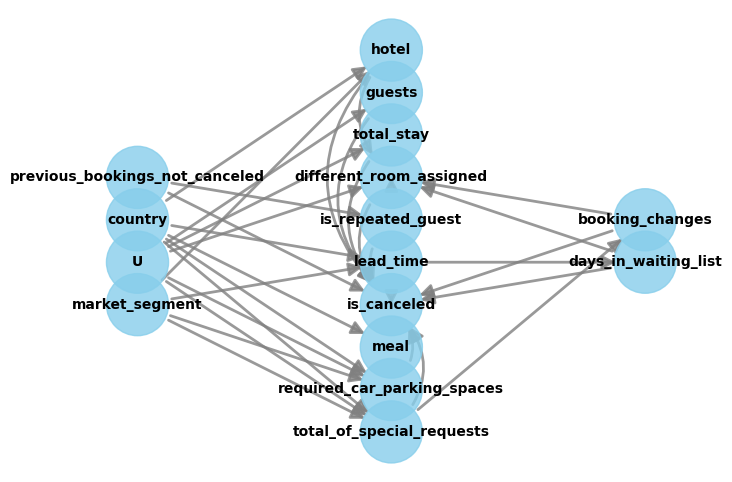

In [28]:
#import pygraphviz
from dowhy import CausalModel
model= CausalModel(
        data = dataset,
        graph=causal_graphStr.replace("\n", " "),
        treatment="different_room_assigned",
        outcome='is_canceled')
model.view_model()
#from IPython.display import Image, display
#display(Image(filename="causal_model.png"))

## Step-2. Identify the Causal Effect
We say that Treatment causes Outcome if changing Treatment leads to a change in Outcome keeping everything else constant. Thus in this step, by using properties of the causal graph, we identify the causal effect to be estimated

In [29]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                  ↪
──────────────────────────(E[is_canceled|total_of_special_requests,required_ca ↪
d[different_room_assigned]                                                     ↪

↪                                                                              ↪
↪ r_parking_spaces,lead_time,is_repeated_guest,guests,total_stay,days_in_waiti ↪
↪                                                                              ↪

↪                                
↪ ng_list,hotel,booking_changes])
↪                                
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,total_of_special_requests,required_car_parking_spaces,lead_time,is_repeated_guest,guests,total_stay,days_in_waiting_list,hotel,booking_changes,U) = P(is_canceled|differ

## Step-3. Estimate the identified estimand

In [30]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_weighting",target_units="ate")
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated (i.e. those who were assigned a different room)
# ATC = Average Treatment Effect on Control (i.e. those who were not assigned a different room)
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                  ↪
──────────────────────────(E[is_canceled|total_of_special_requests,required_ca ↪
d[different_room_assigned]                                                     ↪

↪                                                                              ↪
↪ r_parking_spaces,lead_time,is_repeated_guest,guests,total_stay,days_in_waiti ↪
↪                                                                              ↪

↪                                
↪ ng_list,hotel,booking_changes])
↪                                
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,total_of_special_requests,required_car_parking_spaces,lead_time,is_repeated_guest,guests,total_stay,days_in_waiting_list

The result is surprising. It means that having a different room assigned decreases the chances of a cancellation. There’s more to unpack here: is this the correct causal effect? Could it be that different rooms are assigned only when the booked room is unavailable, and therefore assigning a different room has a positive effect on the customer (as opposed to not assigning a room)?

There could also be other mechanisms at play. Perhaps assigning a different room only happens at check-in, and the chances of a cancellation once the customer is already at the hotel are low? In that case, the graph is missing a critical variable on when these events happen. Does different_room_assigned happen mostly on the day of the booking? Knowing that variable can help improve the graph and our analysis.

While the associational analysis earlier indicated a positive correlation between is_canceled and different_room_assigned, estimating the causal effect using DoWhy presents a different picture. It implies that a decision/policy to reduce the number of different_room_assigned at hotels may be counter-productive.

## Step-4. Refute results
Note that the causal part does not come from data. It comes from your assumptions that lead to identification. Data is simply used for statistical estimation. Thus it becomes critical to verify whether our assumptions were even correct in the first step or not!

What happens when another common cause exists? What happens when the treatment itself was placebo?

## Method-1

Random Common Cause:
Adds randomly drawn covariates to data and re-runs the analysis to see if the causal estimate changes or not. If our assumption was originally correct then the causal estimate shouldn’t change by much.

In [31]:
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

Refute: Add a random common cause
Estimated effect:-0.2622452531023266
New effect:-0.2622452531023266
p value:1.0



# Method-2
Placebo Treatment Refuter:
Randomly assigns any covariate as a treatment and re-runs the analysis. If our assumptions were correct then this newly found out estimate should go to 0.

In [32]:
refute2_results=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")
print(refute2_results)

Refute: Use a Placebo Treatment
Estimated effect:-0.2622452531023266
New effect:0.05361046939373769
p value:0.0



# Method-3
Data Subset Refuter:
Creates subsets of the data(similar to cross-validation) and checks whether the causal estimates vary across subsets. If our assumptions were correct there shouldn’t be much variation.

In [33]:
refute3_results=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter")
print(refute3_results)

Refute: Use a subset of data
Estimated effect:-0.2622452531023266
New effect:-0.261915878031532
p value:0.78



Here is a reference to the interpretation of the [refuters in the DoWhy-Library](https://causalwizard.app/inference/article/bootstrap-refuters-dowhy).